<a href="https://colab.research.google.com/github/zeineb12/text_classification/blob/master/basic_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Relevant-imports" data-toc-modified-id="Relevant-imports-1">Relevant imports</a></span></li><li><span><a href="#Dataset-shape" data-toc-modified-id="Dataset-shape-2">Dataset shape</a></span><ul class="toc-item"><li><span><a href="#Drop-duplicates" data-toc-modified-id="Drop-duplicates-2.1">Drop duplicates</a></span></li></ul></li><li><span><a href="#Tweets-length" data-toc-modified-id="Tweets-length-3">Tweets length</a></span></li><li><span><a href="#Data-concatenation" data-toc-modified-id="Data-concatenation-4">Data concatenation</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-5">Data Cleaning</a></span></li><li><span><a href="#Stop-words-TODO" data-toc-modified-id="Stop-words-TODO-6">Stop words TODO</a></span></li><li><span><a href="#Split-train/validation/test" data-toc-modified-id="Split-train/validation/test-7">Split train/validation/test</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-8">Baseline</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-using-CountVectorizer" data-toc-modified-id="Naive-Bayes-using-CountVectorizer-8.1">Naive Bayes using CountVectorizer</a></span></li><li><span><a href="#Naive-Bayes-using-TfidfTransformer" data-toc-modified-id="Naive-Bayes-using-TfidfTransformer-8.2">Naive Bayes using TfidfTransformer</a></span></li></ul></li><li><span><a href="#Word-cloud-TODO" data-toc-modified-id="Word-cloud-TODO-9">Word cloud TODO</a></span></li></ul></div>

## Relevant imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from utils import open_by_tweets
SEED = 15432

## Dataset shape

In [2]:
with open('data/train_pos.txt',"r") as file:
    train_pos = file.read().split('\n')
train_pos = pd.DataFrame({'tweet' : train_pos})[:len(train_pos)-1]

with open('data/train_neg.txt',"r") as file:
    train_neg = file.read().split('\n')
train_neg = pd.DataFrame({'tweet' : train_neg})[:len(train_neg)-1]

### Drop duplicates
Let's drop duplicates from our dataset

In [3]:
train_neg.drop_duplicates(inplace=True)
train_pos.drop_duplicates(inplace=True)

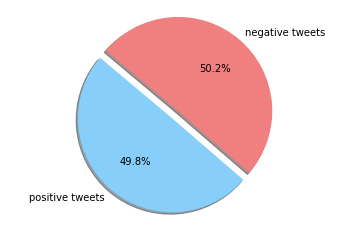

In [4]:
# Data to plot
labels = 'positive tweets', 'negative tweets'
sizes = [len(train_pos), len(train_neg)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We see that the dataset is balanced

## Tweets length
* We add a column containing the tweet length for each tweet (in number of characters)

In [5]:
train_neg['tweet_len'] = [len(t) for t in train_neg.tweet]
train_pos['tweet_len'] = [len(t) for t in train_pos.tweet]

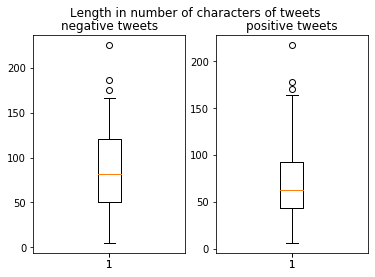

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

ax = axs[0]
ax.boxplot(train_neg.tweet_len, whis=0.7)
ax.set_title('negative tweets')

ax = axs[1]
ax.boxplot(train_pos.tweet_len, whis=1.5)
ax.set_title('positive tweets')

fig.suptitle('Length in number of characters of tweets')
plt.show()

* We see that positive tweets tend to be shorter than negative tweets (mean and std are both smaller)

* However, something that's a bit strange, some of the tweets are way more than 140 characters long. But twitter’s character limit is 140.

In [7]:
train_pos[train_pos.tweet_len > 200].head(4)

,tweet,tweet_len
19278,""" <user> have so much fun at prom <user> \ 355...",217


In [8]:
train_pos.loc[19278].tweet

'" <user> have so much fun at prom <user> \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 227 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 221 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 217 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 213 " yayyy shanny ! ! ! #dodaadirty'

Maybe these numbers used to stand for emojis and when the html text was processed they becaùe like these

In [9]:
re.sub(r'\\ [0-9]+ ','',train_pos.loc[19278].tweet)

'" <user> have so much fun at prom <user> " yayyy shanny ! ! ! #dodaadirty'

## Data concatenation

In [10]:
train_pos['label'] = 1
train_neg['label'] = 0
train_set = train_pos.append(train_neg)
train_set.head(6)

,tweet,tweet_len,label
0,<user> i dunno justin read my mention or not ....,127,1
1,"because your logic is so dumb , i won't even c...",91,1
2,""" <user> just put casper in a box ! "" looved t...",69,1
3,<user> <user> thanks sir > > don't trip lil ma...,78,1
4,visiting my brother tmr is the bestest birthda...,66,1
5,<user> yay ! ! #lifecompleted . tweet / facebo...,73,1


## Data Cleaning

In [11]:
#train_set[train_set['tweet'].str.contains('</3')]#.loc[70514].tweet

In [12]:
def replace_exclamations(x):
    """ Replaces multiple exclamation marks by the word exclamationMark """
    x = re.sub('(\! )+(?=(\!))', '', x)
    x = re.sub(r"(\!)+", ' exclamationMark ', x)
    return x


def replace_questions(x):
    """ Replaces multiple question marks by the word questionMark """
    x = re.sub('(\? )+(?=(\?))', '', x)
    x = re.sub(r"(\?)+", ' questionMark ', x)
    return x


def replace_points(x):
    """ Replaces multiple points by the word multiplePoints """
    x = re.sub('(\. )+(?=(\.))', '', x)
    x = re.sub(r"(\.)+", ' multistop ', x)
    return x

def translate_emojis(x):
    """ Replace emojis into meaningful words """
    x = re.sub(' [:,=]( )*[\),\],},D] ', ' happy ', x) #:) :D :} :]
    x = re.sub(' [:,=]( )*[\(,\[,{,] ', ' sad ', x) #:( :{ :[
    x = re.sub(' X( )*D ', ' funny ', x) #XD
    x = re.sub(' [:,=]( )*p ', ' silly ', x) #:p
    x = re.sub(' [:,=]( )*-( )*p ', ' silly ', x) #:-p
    x = re.sub(' \[( )*[:,=] ', ' happy ', x) #[:
    x = re.sub(' [:,=]( )*[o,0] ', ' surprise ', x) #:o :O
    x = re.sub(' [x,X]+ ', ' kiss ', x) #xXxX
    x = re.sub(' [:,=]( )*\* ', ' kiss ', x) #:*
    x = re.sub(' [:,=]( )*-( )*[D,\)] ', ' happy ', x) #:-D :-)
    x = re.sub(' [:,=]( )*/ ', ' confused ', x) #:/
    x = re.sub(' <( )*3 ', ' love ', x) #<3
    x = re.sub(' <( )*/( )*3 ', ' sad ', x) #</3
    x = re.sub(' [:,=]( )*@ ', ' mad ', x) #:@
    x = re.sub(' [:,=]( )*\'( )*\( ', ' sad ', x) #:'(
    x = re.sub(' [:,=]( )*\'( )*[\),D] ', ' happy ', x) #:') :'D
    x = re.sub('([h,j][a,e,i,o]){2,}', 'haha', x) #hahaha
    return x

def split_negation(text):
    #TODO augment this list with words
    negations_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                    "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                    "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                    "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                    "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dict.keys()) + r')\b')
    text = neg_pattern.sub(lambda x: negations_dict[x.group()], text)
    return text

In [22]:
def tweet_cleaner(tweet):
    #seperate negative words
    tweet = split_negation(tweet)
    #seperate punctuation from words
    tweet = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", tweet)
    #remove the observed pattern of numbers seen above
    tweet = re.sub(r'\\ [0-9]+ ', '', tweet)
    #replace ?,!,. by words
    tweet = replace_exclamations(tweet)
    tweet = replace_questions(tweet)
    tweet = replace_points(tweet)
    #translate emojis
    tweet = translate_emojis(tweet)
    
    #Now since we translated punctuation and emojis and negative words we can remove the rest of the 'unwanted' chars
    #remove unwanted punctuation
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    
    #remove trailing and leading whitespace
    tweet = tweet.strip() 
    #remove multiple consecutive whitespaces
    tweet = re.sub(' +', ' ',tweet)
    #lowercase tweet
    tweet = tweet.lower() 
    
    #correct spelling : deals with goooood -> good
    #b = TextBlob(tweet)
    #tweet = str(b.correct())

    return tweet

In [23]:
test = train_set[:10] 
test['tweet'].apply(tweet_cleaner)

0    user i dunno justin read my mention or not mul...
1    because your logic is so dumb kiss i will not ...
2    user just put casper in a box exclamationmark ...
3    user user thanks sir do not trip lil mama mult...
4    visiting my brother tmr is the bestest birthda...
5    user yay exclamationmark lifecompleted multist...
6    user dnextalbumtitle feel for you rollercoaste...
7    workin hard or hardly workin rt user at hardee...
8    user i saw multistop i ll be replying in a bit...
9                                this is were i belong
Name: tweet, dtype: object

In [24]:
train_set['tweet'] = train_set['tweet'].apply(tweet_cleaner)

In [25]:
train_set['tweet']

0        user i dunno justin read my mention or not mul...
1        because your logic is so dumb kiss i will not ...
2        user just put casper in a box exclamationmark ...
3        user user thanks sir do not trip lil mama mult...
4        visiting my brother tmr is the bestest birthda...
                               ...                        
99995    can not wait to fake tan tonight exclamationma...
99996    user darling i lost my internet connection mul...
99997    kanguru defender basic gb usb multistop flash ...
99998                                     rizan is sad now
99999            no text back questionmark yea kiss he mad
Name: tweet, Length: 181321, dtype: object

In [26]:
train_set.to_pickle("./data/tweets.pkl")

## Stop words TODO

In [28]:
#insert code here just to show that removing stop words makes accuracy worse
#code dan be found here: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-4-count-vectorizer-b3f4944e51b5
#Sami used the same tutorial because in his report there is the exact same plot
#stop_words = ['to','from','at','the','with','a','an',]

## Split train/validation/test

In [37]:
x = train_set.tweet
y = train_set.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=SEED)

In [38]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print( "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 126924 entries with 50.17% negative, 49.83% positive
Validation set has total 27198 entries with 50.08% negative, 49.92% positive
Test set has total 27199 entries with 50.67% negative, 49.33% positive


## Baseline

### Naive Bayes using CountVectorizer 

In [48]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
print('Overall number of different words',len(count_vect.get_feature_names()))
clf = MultinomialNB().fit(x_train_counts, y_train)
y_predicted = clf.predict(count_vect.transform(X_test))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_test, y_predicted)}')

Overall number of different words 73335
Our model's accuracy is 0.7237030773190191


### Naive Bayes using TfidfTransformer

In [54]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
print('Overall number of different words',X_train_tfidf.shape[1])
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_predicted = clf.predict(tfidf_transformer.transform(count_vect.transform(X_test)))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_test, y_predicted)}')

Overall number of different words 73335
Our model's accuracy is 0.7511673223280267


## Word cloud TODO

In [23]:
#insert code here & save files for report
#wordcloud.to_file("img/pos_tweets.png")
#wordcloud.to_file("img/neg_tweets.png")